In [1]:
! pip install langgraph langchain_core langchain-google-genai

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from dotenv import load_dotenv
import os
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image,display
from typing_extensions import TypedDict
from langgraph.errors import NodeInterrupt

load_dotenv()

google_api = os.getenv('GEMINI_API_KEY')
llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=google_api)

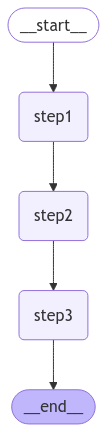

In [11]:
class State(TypedDict):
    input:str
    
def step1(state:State):
    print("-- Node 1 --")
    return state

def step2(state:State):
    if len(state["input"]) > 5 :
        raise NodeInterrupt(f'Received more characters than 5')
    print('-- Node 2 --')
    return state


def step3(state: State) -> State:
    print("---Step 3---")
    return state

builder : StateGraph = StateGraph(State)

builder.add_node('step1',step1)
builder.add_node('step2',step2)
builder.add_node('step3',step3)

builder.set_entry_point('step1')
builder.add_edge('step1','step2')
builder.add_edge('step2','step3')
builder.add_edge('step3',END)

memory = MemorySaver()
graph : CompiledStateGraph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
message = {'input': 'Hi! this is Shahmir'}
config = {'configurable' : {'thread_id':'1'}}
for event in graph.stream(message,config,stream_mode='values'):
     print(event)

{'input': 'Hi! this is Shahmir'}
-- Node 1 --
{'input': 'Hi! this is Shahmir'}


In [14]:
graph.update_state(config,
                {'input':'Hi!'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbbb37-a559-63ea-8005-71e8e223756b'}}

In [16]:
state = graph.get_state(config)
state.next

('step2',)

In [17]:
for event in graph.stream(None, config, stream_mode="values"):
    print(event)

{'input': 'Hi!'}
-- Node 2 --
{'input': 'Hi!'}
---Step 3---
{'input': 'Hi!'}
